## Exploring NLP Pipeline (Part 1)

Here are the 8 stages of NLP PIPLINE

- Data Acquisition,
- Text Extractiong & Cleaning,
- Pre-Processing,
- Feature Engineering,
- Modelling,
- Evaluation
- Deployment
- Monitoring and Model Updating

In [68]:
import nltk
import pandas as pd
import re
import contractions
from nltk.corpus import stopwords
from itertools import chain
from collections import Counter
from string import punctuation
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

## Twitter Sentiment Analysis
With all of the tweets circulating every second, it is hard to tell whether the sentiment behind a specific tweet will impact a company, or a person's, brand for being viral (positive), or devastate profit because it strikes a negative tone. Capturing sentiment in the language is important in these times where decisions and reactions are created and updated in seconds. In this workshop, we'll create an NLP pipeline to predict the sentiment of each tweet.

## Data acquisition
In order to do any type of NLP analysis one requires data to analyze. The twitter data can be collected using the twitter API (https://developer.twitter.com/en/docs/twitter-api). Twitter API is the official programmatic endpoint provided by Twitter. It allows developers to access the enormous amount of public data on Twitter that millions of users share daily.

Tweepy (https://www.tweepy.org/) is an easy-to-use Python library for accessing the Twitter API. Its API class provides access to the RESTful methods of the Twitter API. We will skip the data acquisition process for this workshop in order to keep it short. However, you can develop the process of extracting tweets from Twitter API as an individual project for your portfolio.

## Data extraction
The second step in the NLP pipeline is extracting the text from its native form (such as pdf, image or html files).

Our dataset is a CSV(Comma Separated Values) file that contains tweets data. Each row contains the text of a tweet and a sentiment label. We will use the Pandas library to read the CSV file and load data into a dataframe.

A Pandas DataFrame is a 2 dimensional data structure, like a 2 dimensional array, or a table with rows and columns.

In [69]:
file_path = "/Users/Odera Nnaji/Downloads/Uni Note/NLP/week 2/train_tweets.csv"
file = pd.read_csv(file_path)

In [70]:
file.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [71]:
file.columns

Index(['id', 'label', 'tweet'], dtype='object')

In [72]:
file.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [73]:
len(file)

31962

In [74]:
file.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [75]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [76]:
train_df = file[['tweet', 'label']]
train_df.columns = ['tweet', 'sentiment']

We can count the number of positive and negative tweets using the value_counts() method of a dataframe object.

In [77]:
train_df.sentiment.value_counts()

sentiment
0    29720
1     2242
Name: count, dtype: int64

In [78]:
train_df.head()

,tweet,sentiment
0,@user when a father is dysfunctional and is s...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,0
4,factsguide: society now #motivation,0


The dataset description indicates that:

- 0 ==> positive sentiments
- 1 ==> negative sentiments

According to the result of the previous cell, there are 29,720 positive tweets and 2,242 negative tweets in the training dataset. As a result, the training dataset is imbalanced since the data points are not equal for the two classes.

For storing sentiments, a Python dictionary is an appropriate data structure.

In [79]:
train_df.head(25)

,tweet,sentiment
0,@user when a father is dysfunctional and is s...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,0
4,factsguide: society now #motivation,0
5,[2/2] huge fan fare and big talking before the...,0
6,@user camping tomorrow @user @user @user @use...,0
7,the next school year is the year for exams.ð...,0
8,we won!!! love the land!!! #allin #cavs #champ...,0
9,@user @user welcome here ! i'm it's so #gr...,0


## Text cleaning & pre-processing
Why Do We Need to clean and pre-process Text?

- Extracting plain text: Textual data can come from a wide variety of sources: the web, PDFs, word documents, speech recognition systems, book scans, etc. Your goal is to extract plain text that is free of any source specific markup or constructs that are not relevant to your task.

- Reducing complexity: Some features of our language like capitalization, punctuation, and common words such as a, of, and the, often help provide structure, but don't add much meaning. Sometimes it's best to remove them if that helps reduce the complexity of the procedures you want to apply later.
In order to clean the text of tweets, we will first create a function that lowercase text, expand contractions, removes text enclosed in square brackets, removes links, removes punctuation, and removes words containing numbers.

In [80]:
def clean_text(text):
    # make text lowercase    
    text = str(text).lower()
    # expand contractions
    text = " ".join([contractions.fix(expanded_word) for expanded_word in text.split()])
    # remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # remove links
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    # remove punctuation
    text = re.sub(r'[%s]' % re.escape(punctuation), '', text)
    # remove new lines
    text = re.sub(r'\n', '', text)
    # remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    return text

In [81]:
train_df.head(20)

,tweet,sentiment
0,@user when a father is dysfunctional and is s...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,0
4,factsguide: society now #motivation,0
5,[2/2] huge fan fare and big talking before the...,0
6,@user camping tomorrow @user @user @user @use...,0
7,the next school year is the year for exams.ð...,0
8,we won!!! love the land!!! #allin #cavs #champ...,0
9,@user @user welcome here ! i'm it's so #gr...,0


In [82]:
train_df['clean_tweet'] = train_df['tweet'].apply(clean_text)

In [83]:
train_df.head(20)

,tweet,sentiment,clean_tweet
0,@user when a father is dysfunctional and is s...,0,user when a father is dysfunctional and is so ...
1,@user @user thanks for #lyft credit i can't us...,0,user user thanks for lyft credit i cannot use ...
2,bihday your majesty,0,bihday your majesty
3,#model i love u take with u all the time in ...,0,model i love you take with you all the time in...
4,factsguide: society now #motivation,0,factsguide society now motivation
5,[2/2] huge fan fare and big talking before the...,0,huge fan fare and big talking before they lea...
6,@user camping tomorrow @user @user @user @use...,0,user camping tomorrow user user user user user...
7,the next school year is the year for exams.ð...,0,the next school year is the year for examsð¯...
8,we won!!! love the land!!! #allin #cavs #champ...,0,we won love the land allin cavs champions clev...
9,@user @user welcome here ! i'm it's so #gr...,0,user user welcome here i am it is so


                                                        OR

In [84]:
 train_df['clean_tweet'] = train_df['tweet'].apply(lambda x: clean_text(x))

In [85]:
train_df.head(20)

,tweet,sentiment,clean_tweet
0,@user when a father is dysfunctional and is s...,0,user when a father is dysfunctional and is so ...
1,@user @user thanks for #lyft credit i can't us...,0,user user thanks for lyft credit i cannot use ...
2,bihday your majesty,0,bihday your majesty
3,#model i love u take with u all the time in ...,0,model i love you take with you all the time in...
4,factsguide: society now #motivation,0,factsguide society now motivation
5,[2/2] huge fan fare and big talking before the...,0,huge fan fare and big talking before they lea...
6,@user camping tomorrow @user @user @user @use...,0,user camping tomorrow user user user user user...
7,the next school year is the year for exams.ð...,0,the next school year is the year for examsð¯...
8,we won!!! love the land!!! #allin #cavs #champ...,0,we won love the land allin cavs champions clev...
9,@user @user welcome here ! i'm it's so #gr...,0,user user welcome here i am it is so


Complete the following code to create a column named "no_sentences" containing the number of sentences for each tweet.

In [86]:
def len_sentence(text):
    return len(sent_tokenize(text))

In [87]:
train_df['no_sentence'] = train_df['tweet'].apply(len_sentence)

In [88]:
train_df.head()

,tweet,sentiment,clean_tweet,no_sentence
0,@user when a father is dysfunctional and is s...,0,user when a father is dysfunctional and is so ...,2
1,@user @user thanks for #lyft credit i can't us...,0,user user thanks for lyft credit i cannot use ...,2
2,bihday your majesty,0,bihday your majesty,1
3,#model i love u take with u all the time in ...,0,model i love you take with you all the time in...,2
4,factsguide: society now #motivation,0,factsguide society now motivation,1


                                            OR

In [89]:
train_df['no_sentence'] = train_df['tweet'].apply(lambda x: len(sent_tokenize(x)))

In [90]:
train_df.head()

,tweet,sentiment,clean_tweet,no_sentence
0,@user when a father is dysfunctional and is s...,0,user when a father is dysfunctional and is so ...,2
1,@user @user thanks for #lyft credit i can't us...,0,user user thanks for lyft credit i cannot use ...,2
2,bihday your majesty,0,bihday your majesty,1
3,#model i love u take with u all the time in ...,0,model i love you take with you all the time in...,2
4,factsguide: society now #motivation,0,factsguide society now motivation,1


## Word tokenization
Now we can tokenize tweets into words and extract a list of words for each tweet. We can use the NLTK word tokenizer

In [91]:
def word_token(text):
    return word_tokenize(text)

In [92]:
train_df['word_list'] = train_df['clean_tweet'].apply(word_tokenize)

In [93]:
train_df.head(20)

,tweet,sentiment,clean_tweet,no_sentence,word_list
0,@user when a father is dysfunctional and is s...,0,user when a father is dysfunctional and is so ...,2,"[user, when, a, father, is, dysfunctional, and..."
1,@user @user thanks for #lyft credit i can't us...,0,user user thanks for lyft credit i cannot use ...,2,"[user, user, thanks, for, lyft, credit, i, can..."
2,bihday your majesty,0,bihday your majesty,1,"[bihday, your, majesty]"
3,#model i love u take with u all the time in ...,0,model i love you take with you all the time in...,2,"[model, i, love, you, take, with, you, all, th..."
4,factsguide: society now #motivation,0,factsguide society now motivation,1,"[factsguide, society, now, motivation]"
5,[2/2] huge fan fare and big talking before the...,0,huge fan fare and big talking before they lea...,3,"[huge, fan, fare, and, big, talking, before, t..."
6,@user camping tomorrow @user @user @user @use...,0,user camping tomorrow user user user user user...,1,"[user, camping, tomorrow, user, user, user, us..."
7,the next school year is the year for exams.ð...,0,the next school year is the year for examsð¯...,1,"[the, next, school, year, is, the, year, for, ..."
8,we won!!! love the land!!! #allin #cavs #champ...,0,we won love the land allin cavs champions clev...,3,"[we, won, love, the, land, allin, cavs, champi..."
9,@user @user welcome here ! i'm it's so #gr...,0,user user welcome here i am it is so,2,"[user, user, welcome, here, i, am, it, is, so]"


                                              OR

In [94]:
train_df['word_list'] = train_df['clean_tweet'].apply(lambda x: word_tokenize(x))

In [95]:
train_df.head()

,tweet,sentiment,clean_tweet,no_sentence,word_list
0,@user when a father is dysfunctional and is s...,0,user when a father is dysfunctional and is so ...,2,"[user, when, a, father, is, dysfunctional, and..."
1,@user @user thanks for #lyft credit i can't us...,0,user user thanks for lyft credit i cannot use ...,2,"[user, user, thanks, for, lyft, credit, i, can..."
2,bihday your majesty,0,bihday your majesty,1,"[bihday, your, majesty]"
3,#model i love u take with u all the time in ...,0,model i love you take with you all the time in...,2,"[model, i, love, you, take, with, you, all, th..."
4,factsguide: society now #motivation,0,factsguide society now motivation,1,"[factsguide, society, now, motivation]"


## Finding the most common words in tweets text
Before removing stop words it is worth looking at the tweet's word list and extracting the most common words in tweet texts. This step will help us to understand why we need to remove stop words from the word list.

In the "collections" module of python, you'll find a class specially designed to count several different objects in one go. This class is conveniently called Counter. We use the Counter class to count the number of repetitions of a word in the word list column and then we store the result in a new dataframe.

In [96]:
flattened_word = chain.from_iterable(train_df['word_list'])
top_word = Counter(flattened_word)
temp_df = pd.DataFrame(top_word.most_common(20), columns = ['Words', 'Counts'])
temp_df.style.background_gradient(cmap = 'gist_earth')

,Words,Counts
0,user,17474
1,the,10156
2,to,10089
3,you,7510
4,i,7288
5,a,6416
6,is,6108
7,and,4871
8,in,4638
9,for,4479


                                                OR

## Stop words removal

As you can see, many of the most commonly used words are not useful for identifying tweet sentiment. They belong to the stop words list and should be removed from the tweets words list.

In [97]:
stopword = set(stopwords.words('english'))

In [98]:
def remove_stopwords(word_list):

    return [word for word in word_list if word not in stopword]

In [99]:
train_df['word_list_without_sw'] = train_df['word_list'].apply(remove_stopwords)

In [100]:
train_df.head(20)

,tweet,sentiment,clean_tweet,no_sentence,word_list,word_list_without_sw
0,@user when a father is dysfunctional and is s...,0,user when a father is dysfunctional and is so ...,2,"[user, when, a, father, is, dysfunctional, and...","[user, father, dysfunctional, selfish, drags, ..."
1,@user @user thanks for #lyft credit i can't us...,0,user user thanks for lyft credit i cannot use ...,2,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, lyft, credit, use, offer,..."
2,bihday your majesty,0,bihday your majesty,1,"[bihday, your, majesty]","[bihday, majesty]"
3,#model i love u take with u all the time in ...,0,model i love you take with you all the time in...,2,"[model, i, love, you, take, with, you, all, th...","[model, love, take, time, areð±, ððð..."
4,factsguide: society now #motivation,0,factsguide society now motivation,1,"[factsguide, society, now, motivation]","[factsguide, society, motivation]"
5,[2/2] huge fan fare and big talking before the...,0,huge fan fare and big talking before they lea...,3,"[huge, fan, fare, and, big, talking, before, t...","[huge, fan, fare, big, talking, leave, chaos, ..."
6,@user camping tomorrow @user @user @user @use...,0,user camping tomorrow user user user user user...,1,"[user, camping, tomorrow, user, user, user, us...","[user, camping, tomorrow, user, user, user, us..."
7,the next school year is the year for exams.ð...,0,the next school year is the year for examsð¯...,1,"[the, next, school, year, is, the, year, for, ...","[next, school, year, year, examsð¯, think, ð..."
8,we won!!! love the land!!! #allin #cavs #champ...,0,we won love the land allin cavs champions clev...,3,"[we, won, love, the, land, allin, cavs, champi...","[love, land, allin, cavs, champions, cleveland..."
9,@user @user welcome here ! i'm it's so #gr...,0,user user welcome here i am it is so,2,"[user, user, welcome, here, i, am, it, is, so]","[user, user, welcome]"


                                                            OR

In [101]:
train_df['word_list_without_sw'] = train_df['word_list'].apply(lambda x: remove_stopwords(x))

In [102]:
train_df.head()

,tweet,sentiment,clean_tweet,no_sentence,word_list,word_list_without_sw
0,@user when a father is dysfunctional and is s...,0,user when a father is dysfunctional and is so ...,2,"[user, when, a, father, is, dysfunctional, and...","[user, father, dysfunctional, selfish, drags, ..."
1,@user @user thanks for #lyft credit i can't us...,0,user user thanks for lyft credit i cannot use ...,2,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, lyft, credit, use, offer,..."
2,bihday your majesty,0,bihday your majesty,1,"[bihday, your, majesty]","[bihday, majesty]"
3,#model i love u take with u all the time in ...,0,model i love you take with you all the time in...,2,"[model, i, love, you, take, with, you, all, th...","[model, love, take, time, areð±, ððð..."
4,factsguide: society now #motivation,0,factsguide society now motivation,1,"[factsguide, society, now, motivation]","[factsguide, society, motivation]"


In [103]:
flat_words  = chain.from_iterable(train_df['word_list_without_sw'])
Top = Counter(flat_words)
tempdf = pd.DataFrame(Top.most_common(20), columns = ['Words', 'Count'])
tempdf.style.background_gradient(cmap = 'Purples')

,Words,Count
0,user,17474
1,love,2668
2,day,2198
3,happy,1663
4,amp,1582
5,time,1110
6,life,1086
7,like,1042
8,â¦,1004
9,today,991


## Most common words sentiments wise
As a result of this process, we can see some meaningful words among the most common words. As we have more positive tweets in our dataset, positive words have a larger proportion. We can check the most common word in both negative and positive tweets separately. In the following cell, we will create two separate dataframes for each sentiment and repeat the above process.

In [104]:
# create seperate dataframes for each sentiment
Positive_sentiment = train_df[train_df['sentiment'] == 'Positive']
Negative_sentiment = train_df[train_df['sentiment'] == 'Negative']

In [105]:
positive_sent = Positive_sentiment['word_list_without_sw']
flat_word = chain.from_iterable(positive_sent)
topwords = Counter(flat_word)
tmpdf = pd.DataFrame(topwords.most_common(20), columns = ['Words', 'Counts'])
tmpdf = tmpdf.iloc[1:,:]
tmpdf.style.background_gradient(cmap = 'Reds')

,Words,Counts


In [106]:
negative_sent = Negative_sentiment['word_list_without_sw']
fflatwords = chain.from_iterable(negative_sent)
topwording = Counter(fflatwords)
tmpdfs = pd.DataFrame(topwording.most_common(20), columns= ['Words', 'Counts'])
tmpdfs = tmpdfs.iloc[1:,:]
tmpdfs.style.background_gradient(cmap = 'nipy_spectral_r')

,Words,Counts


## Lemmatization
Both stemming and lemmatization converts word to its base form. Stemming is a fast rule based technique and sometimes chops off inaccurately (under-stemming and over-stemming). You may have noticed NLTK provides PorterStemmer and a slightly improved Snowball Stemmer.

Lemmatization is dictionary based technique, more accurate but slightly slower than stemming. We will use WordnetLemmatizer from NLTK. We will download the wordnet resource for this purpose.

In [107]:
lemmatizer = WordNetLemmatizer()

In [108]:
def lemmatize_word(word_list_without_sw):
    return [lemmatizer.lemmatize(word, pos = 'r') for word in word_list_without_sw]

In [109]:
train_df['Lemmatized_word'] = train_df['word_list_without_sw'].apply(lemmatize_word)

In [110]:
train_df.head(50)

,tweet,sentiment,clean_tweet,no_sentence,word_list,word_list_without_sw,Lemmatized_word
0,@user when a father is dysfunctional and is s...,0,user when a father is dysfunctional and is so ...,2,"[user, when, a, father, is, dysfunctional, and...","[user, father, dysfunctional, selfish, drags, ...","[user, father, dysfunctional, selfish, drags, ..."
1,@user @user thanks for #lyft credit i can't us...,0,user user thanks for lyft credit i cannot use ...,2,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, lyft, credit, use, offer,...","[user, user, thanks, lyft, credit, use, offer,..."
2,bihday your majesty,0,bihday your majesty,1,"[bihday, your, majesty]","[bihday, majesty]","[bihday, majesty]"
3,#model i love u take with u all the time in ...,0,model i love you take with you all the time in...,2,"[model, i, love, you, take, with, you, all, th...","[model, love, take, time, areð±, ððð...","[model, love, take, time, areð±, ððð..."
4,factsguide: society now #motivation,0,factsguide society now motivation,1,"[factsguide, society, now, motivation]","[factsguide, society, motivation]","[factsguide, society, motivation]"
5,[2/2] huge fan fare and big talking before the...,0,huge fan fare and big talking before they lea...,3,"[huge, fan, fare, and, big, talking, before, t...","[huge, fan, fare, big, talking, leave, chaos, ...","[huge, fan, fare, big, talking, leave, chaos, ..."
6,@user camping tomorrow @user @user @user @use...,0,user camping tomorrow user user user user user...,1,"[user, camping, tomorrow, user, user, user, us...","[user, camping, tomorrow, user, user, user, us...","[user, camping, tomorrow, user, user, user, us..."
7,the next school year is the year for exams.ð...,0,the next school year is the year for examsð¯...,1,"[the, next, school, year, is, the, year, for, ...","[next, school, year, year, examsð¯, think, ð...","[next, school, year, year, examsð¯, think, ð..."
8,we won!!! love the land!!! #allin #cavs #champ...,0,we won love the land allin cavs champions clev...,3,"[we, won, love, the, land, allin, cavs, champi...","[love, land, allin, cavs, champions, cleveland...","[love, land, allin, cavs, champions, cleveland..."
9,@user @user welcome here ! i'm it's so #gr...,0,user user welcome here i am it is so,2,"[user, user, welcome, here, i, am, it, is, so]","[user, user, welcome]","[user, user, welcome]"


                                                        OR

In [111]:
train_df['Lemmatized_word'] = train_df['word_list_without_sw'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [112]:
train_df.head(20)

,tweet,sentiment,clean_tweet,no_sentence,word_list,word_list_without_sw,Lemmatized_word
0,@user when a father is dysfunctional and is s...,0,user when a father is dysfunctional and is so ...,2,"[user, when, a, father, is, dysfunctional, and...","[user, father, dysfunctional, selfish, drags, ...","[user, father, dysfunctional, selfish, drag, k..."
1,@user @user thanks for #lyft credit i can't us...,0,user user thanks for lyft credit i cannot use ...,2,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, lyft, credit, use, offer,...","[user, user, thanks, lyft, credit, use, offer,..."
2,bihday your majesty,0,bihday your majesty,1,"[bihday, your, majesty]","[bihday, majesty]","[bihday, majesty]"
3,#model i love u take with u all the time in ...,0,model i love you take with you all the time in...,2,"[model, i, love, you, take, with, you, all, th...","[model, love, take, time, areð±, ððð...","[model, love, take, time, areð±, ððð..."
4,factsguide: society now #motivation,0,factsguide society now motivation,1,"[factsguide, society, now, motivation]","[factsguide, society, motivation]","[factsguide, society, motivation]"
5,[2/2] huge fan fare and big talking before the...,0,huge fan fare and big talking before they lea...,3,"[huge, fan, fare, and, big, talking, before, t...","[huge, fan, fare, big, talking, leave, chaos, ...","[huge, fan, fare, big, talking, leave, chaos, ..."
6,@user camping tomorrow @user @user @user @use...,0,user camping tomorrow user user user user user...,1,"[user, camping, tomorrow, user, user, user, us...","[user, camping, tomorrow, user, user, user, us...","[user, camping, tomorrow, user, user, user, us..."
7,the next school year is the year for exams.ð...,0,the next school year is the year for examsð¯...,1,"[the, next, school, year, is, the, year, for, ...","[next, school, year, year, examsð¯, think, ð...","[next, school, year, year, examsð¯, think, ð..."
8,we won!!! love the land!!! #allin #cavs #champ...,0,we won love the land allin cavs champions clev...,3,"[we, won, love, the, land, allin, cavs, champi...","[love, land, allin, cavs, champions, cleveland...","[love, land, allin, cavs, champion, cleveland,..."
9,@user @user welcome here ! i'm it's so #gr...,0,user user welcome here i am it is so,2,"[user, user, welcome, here, i, am, it, is, so]","[user, user, welcome]","[user, user, welcome]"


## Final pre-processing
Let's to concatinate all the words in the last column on the dataframe and create a cleaned version of tweet text.

In [113]:
train_df['final_tweet'] = train_df['Lemmatized_word'].apply(lambda x:' '.join(x))

In [114]:
train_df.head(20)

,tweet,sentiment,clean_tweet,no_sentence,word_list,word_list_without_sw,Lemmatized_word,final_tweet
0,@user when a father is dysfunctional and is s...,0,user when a father is dysfunctional and is so ...,2,"[user, when, a, father, is, dysfunctional, and...","[user, father, dysfunctional, selfish, drags, ...","[user, father, dysfunctional, selfish, drag, k...",user father dysfunctional selfish drag kid dys...
1,@user @user thanks for #lyft credit i can't us...,0,user user thanks for lyft credit i cannot use ...,2,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thanks, lyft, credit, use, offer,...","[user, user, thanks, lyft, credit, use, offer,...",user user thanks lyft credit use offer wheelch...
2,bihday your majesty,0,bihday your majesty,1,"[bihday, your, majesty]","[bihday, majesty]","[bihday, majesty]",bihday majesty
3,#model i love u take with u all the time in ...,0,model i love you take with you all the time in...,2,"[model, i, love, you, take, with, you, all, th...","[model, love, take, time, areð±, ððð...","[model, love, take, time, areð±, ððð...",model love take time areð± ðððð ð...
4,factsguide: society now #motivation,0,factsguide society now motivation,1,"[factsguide, society, now, motivation]","[factsguide, society, motivation]","[factsguide, society, motivation]",factsguide society motivation
5,[2/2] huge fan fare and big talking before the...,0,huge fan fare and big talking before they lea...,3,"[huge, fan, fare, and, big, talking, before, t...","[huge, fan, fare, big, talking, leave, chaos, ...","[huge, fan, fare, big, talking, leave, chaos, ...",huge fan fare big talking leave chaos pay disp...
6,@user camping tomorrow @user @user @user @use...,0,user camping tomorrow user user user user user...,1,"[user, camping, tomorrow, user, user, user, us...","[user, camping, tomorrow, user, user, user, us...","[user, camping, tomorrow, user, user, user, us...",user camping tomorrow user user user user user...
7,the next school year is the year for exams.ð...,0,the next school year is the year for examsð¯...,1,"[the, next, school, year, is, the, year, for, ...","[next, school, year, year, examsð¯, think, ð...","[next, school, year, year, examsð¯, think, ð...",next school year year examsð¯ think ð­ sch...
8,we won!!! love the land!!! #allin #cavs #champ...,0,we won love the land allin cavs champions clev...,3,"[we, won, love, the, land, allin, cavs, champi...","[love, land, allin, cavs, champions, cleveland...","[love, land, allin, cavs, champion, cleveland,...",love land allin cavs champion cleveland clevel...
9,@user @user welcome here ! i'm it's so #gr...,0,user user welcome here i am it is so,2,"[user, user, welcome, here, i, am, it, is, so]","[user, user, welcome]","[user, user, welcome]",user user welcome


In [115]:
from sklearn.feature_extraction.text import CountVectorizer

# create a count vertorizer object and set the size of the vocabulary to 8000
cv = CountVectorizer(max_features = 8000, ngram_range = (1,2))

# convert the dtype of final tweet column to unicode string and convert them to bag of words
X = cv.fit_transform(train_df['final_tweet'].values.astype('U')).toarray()
y = train_df['sentiment']

In [116]:
print("X: ", X[0:5])
print("y: ",y[0:5])

X:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
y:  0    0
1    0
2    0
3    0
4    0
Name: sentiment, dtype: int64


In [117]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("number of tweets in training dataset: ", len(X_train))
print("number of tweets in testing dataset: ", len(X_test))

number of tweets in training dataset:  25569
number of tweets in testing dataset:  6393


In [118]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [119]:
mnb_model = MultinomialNB()
bnb_model = BernoulliNB()
lr_model = LogisticRegression(max_iter = 300, multi_class = "multinomial")
rfc_model = RandomForestClassifier(n_estimators = 50, random_state = 2, max_depth = 25)
tree_model = DecisionTreeClassifier(max_depth = 30)

In [120]:
def train_classifier_get_confusion_metric(model, X_train, y_train, X_test, y_test):
    # train the model on training data
    model.fit(X_train, y_train)
    
    # evaluate the model
    y_pred = model.predict(X_test)

    # calculate the performance metrics
    confusion = confusion_matrix(y_test, y_pred)

    return confusion

Confusion Matrix:  [[5883   54]
 [ 213  243]]


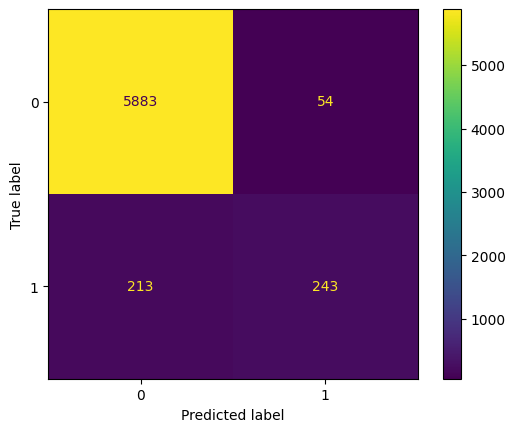

In [121]:
lr_confusion = train_classifier_get_confusion_metric(lr_model, X_train, y_train, X_test, y_test)

print("Confusion Matrix: ", lr_confusion)
disp = ConfusionMatrixDisplay(lr_confusion, display_labels = map.keys())
disp.plot()
plt.show()

## Exercise
1- Calculate the accuracy of the liner regression model.

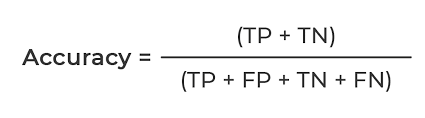

In [122]:
#Calculate the accuracy of the model
lr_accuracy = (5580 + 243) / (5580 + 57 + 214 + 242)
print(lr_accuracy)

0.9556868537666174


## Exercise
1- Calculate the percision of the liner regression model.
![image.png](attachment:d8c7988c-54ad-4f9f-bbee-5822dca9a302.png)

In [125]:
# calculate the precision of the model
lr_precision = (243) / (243 + 54)
print(lr_precision)

0.8181818181818182


Model:  Multinomial Naive Bayes
Accuracy:  0.9502580947911778
Precision:  0.6342412451361867
Recall:  0.7149122807017544
F1:  0.6721649484536083
Confusion Matrix:  [[5749  188]
 [ 130  326]]


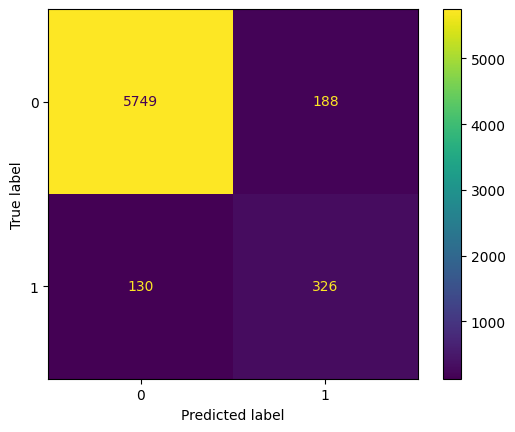

--------------------------------------------------
Model:  Bernoulli Naive Bayes
Accuracy:  0.9496324104489285
Precision:  0.6610576923076923
Recall:  0.6030701754385965
F1:  0.6307339449541285
Confusion Matrix:  [[5796  141]
 [ 181  275]]


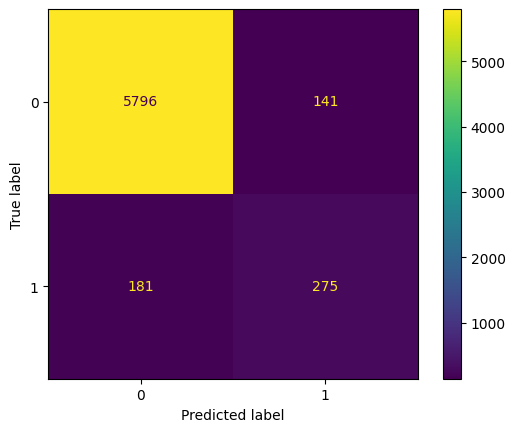

--------------------------------------------------
Model:  Logistic Regression
Accuracy:  0.9582355701548568
Precision:  0.8181818181818182
Recall:  0.5328947368421053
F1:  0.6454183266932271
Confusion Matrix:  [[5883   54]
 [ 213  243]]


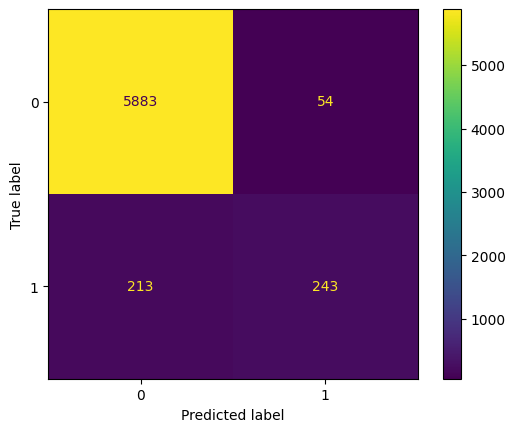

--------------------------------------------------
Model:  Random Forest Classifier
Accuracy:  0.9380572501173158
Precision:  1.0
Recall:  0.13157894736842105
F1:  0.23255813953488372
Confusion Matrix:  [[5937    0]
 [ 396   60]]


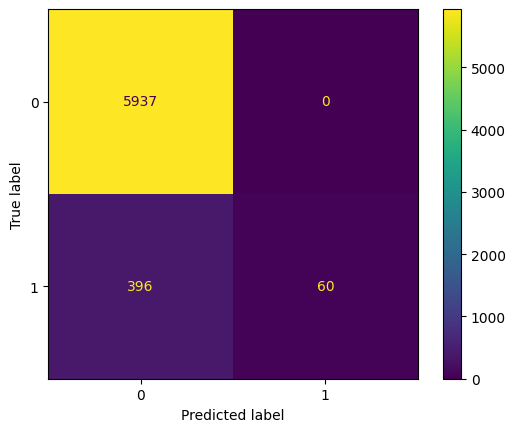

--------------------------------------------------
Model:  Decision Tree Classifier
Accuracy:  0.9491631471922415
Precision:  0.8164251207729468
Recall:  0.3706140350877193
F1:  0.5098039215686274
Confusion Matrix:  [[5899   38]
 [ 287  169]]


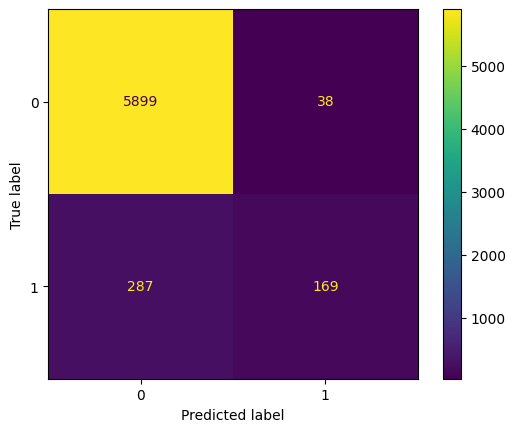

--------------------------------------------------


In [124]:
def train_classifier(model, X_train, y_train, X_test, y_test):
    # train the model on training data
    model.fit(X_train, y_train)
    
    # evaluate the model
    y_pred = model.predict(X_test)

    # calculate the performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, precision, confusion, recall, f1

# create a dictionary of models
models = {
    'Multinomial Naive Bayes': mnb_model,
    'Bernoulli Naive Bayes': bnb_model,
    'Logistic Regression': lr_model,
    'Random Forest Classifier': rfc_model,
    'Decision Tree Classifier': tree_model
}

# create a list to store performance of models
accuracy_scores = []
precision_scores = []
confusions = []
recall_scores = []
f1_scores = []

for model_name, model in models.items():
    
    # train the model on training data
    cur_accuracy, cur_precision, cur_confusion, cur_recall, cur_f1 = train_classifier(model, X_train, y_train, X_test, y_test)

    # print model performance
    print("Model: " , model_name)
    print("Accuracy: ", cur_accuracy)
    print("Precision: ", cur_precision)
    print("Recall: ", cur_recall)
    print("F1: ", cur_f1)
    print("Confusion Matrix: ", cur_confusion)
    disp = ConfusionMatrixDisplay(cur_confusion, display_labels = map.keys())
    disp.plot()
    plt.show()
    
    print('-' * 50)

    # append the performance metrics to a list
    accuracy_scores.append(cur_accuracy)
    precision_scores.append(cur_precision)
    confusions.append(cur_confusion)
    recall_scores.append(cur_recall)
    f1_scores.append(cur_f1)

In [126]:
performance_df = pd.DataFrame({'Algorithm': models.keys(), 
                                'Accuracy': accuracy_scores, 
                                'Precision': precision_scores, 
                                'Recall': recall_scores, 
                                'F1': f1_scores,
                                'Confusion': confusions}).sort_values("Accuracy", ascending = False, ignore_index = True)

performance_df

,Algorithm,Accuracy,Precision,Recall,F1,Confusion
0,Logistic Regression,0.958236,0.818182,0.532895,0.645418,"[[5883, 54], [213, 243]]"
1,Multinomial Naive Bayes,0.950258,0.634241,0.714912,0.672165,"[[5749, 188], [130, 326]]"
2,Bernoulli Naive Bayes,0.949632,0.661058,0.603070,0.630734,"[[5796, 141], [181, 275]]"
3,Decision Tree Classifier,0.949163,0.816425,0.370614,0.509804,"[[5899, 38], [287, 169]]"
4,Random Forest Classifier,0.938057,1.000000,0.131579,0.232558,"[[5937, 0], [396, 60]]"


In [127]:
import pickle

file_name = "LogisticRegression.pickle"
pickle.dump(lr_model, open(file_name, "wb"))